# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-19 00:56:17--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M   763KB/s    in 77s     

2022-09-19 00:57:34 (1.46 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

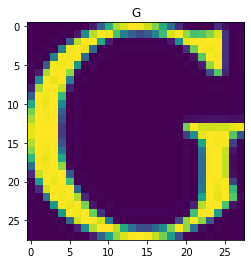

In [6]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

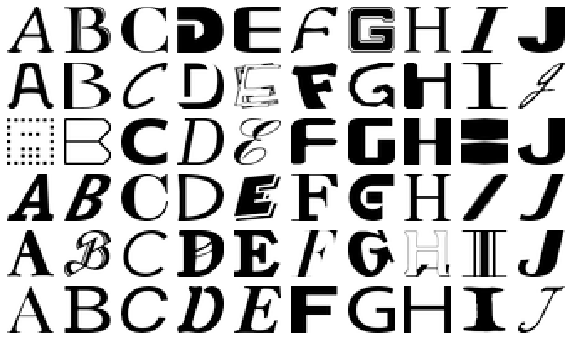

In [7]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [8]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [9]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

In [14]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [23]:
from tensorflow.keras.utils import to_categorical 

In [24]:
n = len(np.unique(y_train))
n

10

In [25]:
y_train = to_categorical(y_train, n)
y_test = to_categorical(y_test, n)

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Optimizer를 따로 선언해서 사용
3. Dropout을 0.2 정도로 활용해볼 것
4. 초기값은 default로
5. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
6. Early stopping도 활용해볼 것

In [10]:
import tensorflow as tf
from tensorflow import keras

In [33]:
from keras.backend import clear_session
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
clear_session()

il = Input(shape=(28,28,1))
fl = Flatten()(il)

hl = Dense(64, activation='swish')(fl)
bnl = BatchNormalization()(hl)

hl = Dense(64, activation='swish')(bnl)
bnl = BatchNormalization()(hl)

hl = Dense(64, activation='swish')(bnl)
bnl = BatchNormalization()(hl)

dol = Dropout(rate=0.2)(bnl)

ol = Dense(n, activation='softmax')(dol)

model = Model(il, ol)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [37]:
mcp = ModelCheckpoint(filepath='/content/model.ckpt',
                      monito='val_loss',
                      verbose=1,
                      save_best_only=True,    # best 만 저장
                      save_weights_only=False) # True 시 가중치만 저장, False 만든 모델도 저장

In [38]:
model.fit(x_train,
          y_train,
          epochs=1000,
          verbose=1,
          callbacks=[es, mcp],
          validation_split=0.2)

Epoch 1/1000
370/375 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9493
Epoch 1: val_loss improved from inf to 0.42267, saving model to /content/model.ckpt
375/375 [==============================] - 4s 9ms/step - loss: 0.1616 - accuracy: 0.9493 - val_loss: 0.4227 - val_accuracy: 0.8942
Epoch 2/1000
362/375 [===========================>..] - ETA: 0s - loss: 0.1606 - accuracy: 0.9489
Epoch 2: val_loss improved from 0.42267 to 0.41402, saving model to /content/model.ckpt
375/375 [==============================] - 3s 8ms/step - loss: 0.1603 - accuracy: 0.9489 - val_loss: 0.4140 - val_accuracy: 0.8972
Epoch 3/1000
362/375 [===========================>..] - ETA: 0s - loss: 0.1498 - accuracy: 0.9524
Epoch 3: val_loss did not improve from 0.41402
375/375 [==============================] - 1s 3ms/step - loss: 0.1507 - accuracy: 0.9520 - val_loss: 0.4432 - val_accuracy: 0.8949
Epoch 4/1000
361/375 [===========================>..] - ETA: 0s - loss: 0.1378 - accuracy: 0.9